# Clinically active contacts and oscillations recorded with BSSu

Import Packages

In [1]:


import os
import sys
import importlib
from importlib import reload 
from dataclasses import dataclass, field, fields
from itertools import compress
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

import scipy
import scipy.io as sio
from scipy import signal
from scipy.signal import spectrogram, hann, butter, filtfilt, freqz
from scipy import stats

import seaborn as sns
import pingouin as pg
import itertools
from itertools import combinations
from statannotations.Annotator import Annotator
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
import plotly.express as px

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report

# import openpyxl
# from openpyxl import Workbook, load_workbook
# import xlrd
import pickle
import json
import csv

#mne
import mne_bids
import mne
from mne.time_frequency import tfr_morlet 
from mne.stats import permutation_cluster_test


# TODO: add README file: 
# pip install pingouin
# pip install statannotations
# pip install fooof

In [2]:
import py_perceive

from py_perceive.PerceiveImport.classes import (
    main_class, modality_class, metadata_class,
    session_class, condition_class, task_class,
    contact_class, run_class
)
import py_perceive.PerceiveImport.methods.load_rawfile as load_rawfile
import py_perceive.PerceiveImport.methods.find_folders as find_folders
import py_perceive.PerceiveImport.methods.metadata_helpers as metaHelpers


importlib.reload(main_class)
importlib.reload(session_class)
importlib.reload(task_class)
importlib.reload(condition_class)
importlib.reload(contact_class)
importlib.reload(metadata_class)
importlib.reload(modality_class)
importlib.reload(load_rawfile)
importlib.reload(find_folders)
importlib.reload(run_class)
importlib.reload(metaHelpers)

<module 'py_perceive.PerceiveImport.methods.metadata_helpers' from 'C:\\Users\\jebe12\\Research\\PyPerceive_Project\\Code\\PyPerceive\\src\\py_perceive\\PerceiveImport\\methods\\metadata_helpers.py'>

In [3]:
#######################     USE THIS DIRECTORY FOR WORKING WITH FOLDERS INSIDE OF CODE FOLDER OF BETASENSIGHTLONGTERM REPO  #######################


# create a path to the BetaSenSightLongterm folder 
# and a path to the code folder within the BetaSenSightLongterm Repo
current_path = os.getcwd()
while current_path[-8:] != 'Research':
    current_path = os.path.dirname(current_path)

# directory to code folder
code_path = os.path.join(current_path, 'Longterm_beta_project','Code', 'meet')
sys.path.append(code_path)

# # change directory to code path within BetaSenSightLongterm Repo
os.chdir(code_path)
os.getcwd()

import meet as meet


'c:\\Users\\jebe12\\Research\\Longterm_beta_project\\Code\\BetaSenSightLongterm'

In [ ]:
#######################     USE THIS DIRECTORY FOR WORKING WITH FOLDERS INSIDE OF CODE FOLDER OF BETASENSIGHTLONGTERM REPO  #######################


# create a path to the BetaSenSightLongterm folder 
# and a path to the code folder within the BetaSenSightLongterm Repo
current_path = os.getcwd()
while current_path[-8:] != 'Research':
    current_path = os.path.dirname(current_path)

# directory to code folder
code_path = os.path.join(current_path, 'Longterm_beta_project','Code', 'BetaSenSightLongterm')
sys.path.append(code_path)

# # change directory to code path within BetaSenSightLongterm Repo
os.chdir(code_path)
os.getcwd()

In [5]:

# tfr, processing
import src.bssu.tfr.BSSuPsd as BSSuPsd
import src.bssu.tfr.FastFourierPSD as FFpsd

# bipolar Channel Analysis
import src.bssu.bipolar.power_spectra_plots as power_spectra_plots
import src.bssu.bipolar.PeakFrequencies_PSD as PeakFrequency_psd
import src.bssu.bipolar.BIP_channelGroups as BIP_channelGroups
import src.bssu.bipolar.BIP_perChannelAnalysis as BIP_perChannel
import src.bssu.bipolar.cluster_perm as cluster_perm


# monopolar Referencing
import src.bssu.monopolar.MonoRef_JLB as MonoRefJLB
import src.bssu.monopolar.GroupMonopolarPSD as groupMonopol

# Ranking Order
import src.bssu.ranking.HighestRankedChannelPSD as highestRank
import src.bssu.ranking.monopolPSDaverage_withinSubject as PSDaverageMonopol
import src.bssu.ranking.BIPchannelGroups_ranks as BIP_ranks
import src.bssu.ranking.Permutation_rankings as Permute_ranks


# Clinical stimulation parameters
import src.bssu.stimulation.activeStimulationContacts as activeStimContacts

# utility functions
import src.bssu.utils.loadResults as loadResults
import src.bssu.utils.find_folders as find_folders
import src.bssu.utils.writeGroupDataframes as writeGroupDF

# import Classes
from src.bssu.classes import (metadataAnalysis_class, mainAnalysis_class, sessionAnalysis_class, 
                              channelAnalysis_class, featureAnalysis_class, frequencyBand_class)

# import mni coordinates
import src.bssu.mni.load_rotated_coordinates as load_mni


importlib.reload(BSSuPsd)
importlib.reload(MonoRefJLB)
importlib.reload(loadResults)
importlib.reload(highestRank)
importlib.reload(groupMonopol)
importlib.reload(PSDaverageMonopol)
importlib.reload(FFpsd)
importlib.reload(find_folders)
importlib.reload(metadataAnalysis_class)
importlib.reload(mainAnalysis_class)
importlib.reload(sessionAnalysis_class)
importlib.reload(channelAnalysis_class)
importlib.reload(featureAnalysis_class)
importlib.reload(frequencyBand_class)
importlib.reload(PeakFrequency_psd)
importlib.reload(power_spectra_plots)
importlib.reload(BIP_channelGroups)
importlib.reload(BIP_ranks)
importlib.reload(activeStimContacts)
importlib.reload(Permute_ranks)
importlib.reload(BIP_perChannel)
importlib.reload(load_mni)
importlib.reload(writeGroupDF)
importlib.reload(cluster_perm)

<module 'src.bssu.bipolar.cluster_perm' from 'c:\\Users\\jebe12\\Research\\Longterm_beta_project\\Code\\BetaSenSightLongterm\\src\\bssu\\bipolar\\cluster_perm.py'>

## 1. Longitundial change of clinically active contacts 

In [6]:
activeLevels = activeStimContacts.bestClinicalStimContacts_LevelsComparison()

Excel file loaded:  BestClinicalStimulation.xlsx 
loaded from:  c:\Users\jebe12\Research\Longterm_beta_project\data


KeyError: 'compareLevels'

In [7]:
file = loadResults.load_BestClinicalStimulation_excel()

Excel file loaded:  BestClinicalStimulation.xlsx 
loaded from:  c:\Users\jebe12\Research\Longterm_beta_project\data


In [8]:
contactLevels_all = file["compareLevels"]

# select only fu3m rows and fu12m rows and merge
fu3m_level = contactLevels_all[contactLevels_all.session == "fu3m"]
fu12m_level = contactLevels_all[contactLevels_all.session == "fu12m"]
comparefu3m_fu12m = fu3m_level.merge(fu12m_level, left_on="subject_hemisphere", right_on="subject_hemisphere")
comparefu3m_fu12m.dropna(axis=0) # delete rows with NaNs

# calculate the difference between levels, add to a new column
comparefu3m_fu12m["difference_levels"] = (comparefu3m_fu12m["ContactLevel_x"] - comparefu3m_fu12m["ContactLevel_y"]).apply(abs)
comparefu3m_fu12m.dropna(axis=0)

KeyError: 'compareLevels'

In [ ]:
# select only fu12m rows and longterm rows and merge

fu12m_level = contactLevels_all[contactLevels_all.session == "fu12m"]
longterm_level = contactLevels_all[(contactLevels_all.session == "fu18m") | (contactLevels_all.session == "fu20m") | (contactLevels_all.session == "fu22m")] # use | instead of or here 
comparefu12m_longterm= fu12m_level.merge(longterm_level, left_on="subject_hemisphere", right_on="subject_hemisphere")
comparefu12m_longterm.dropna(axis=0) 

# calculate the difference between levels, add to a new column
comparefu12m_longterm["difference_levels"] = (comparefu12m_longterm["ContactLevel_x"] - comparefu12m_longterm["ContactLevel_y"]).apply(abs)
comparefu12m_longterm.dropna(axis=0)

In [ ]:
colors0 = sns.color_palette("viridis", n_colors=len(comparefu3m_fu12m.index))
colors1 = sns.color_palette("viridis", n_colors=len(comparefu12m_longterm.index))

fontdict = {"size": 25}

fig, axes  = plt.subplots(2, 1, figsize=(10,15))

sns.histplot(data=comparefu3m_fu12m, x="difference_levels", stat="count", hue="subject_hemisphere", 
             multiple="stack", bins=np.arange(-0.25,4,0.5),
             palette=colors0, ax=axes[0])

axes[0].set_title("3MFU vs. 12MFU", fontdict=fontdict)

legend1 = axes[0].get_legend()
handles = legend1.legendHandles

legend_list1 = list(comparefu3m_fu12m.subject_hemisphere.values)
axes[0].legend(handles, legend_list1, title='subject hemisphere',  title_fontsize=15, fontsize=15)


sns.histplot(data=comparefu12m_longterm, x="difference_levels", stat="count", hue="subject_hemisphere", 
             multiple="stack", bins=np.arange(-0.25,4,0.5),
             palette=colors1, ax= axes[1])

axes[1].set_title("12MFU vs. longterm-FU (18, 20, 22MFU)", fontdict=fontdict)
legend2 = axes[1].get_legend()
handles = legend2.legendHandles

legend_list2 = list(comparefu12m_longterm.subject_hemisphere.values)
axes[1].legend(handles, legend_list2, title='subject hemisphere', title_fontsize=15, fontsize=15)


for ax in axes:

    ax.set_xlabel("difference between contact levels",  fontsize=25)
    ax.set_ylabel("Count", fontsize=25)
    # ax.set_xticks(fontsize=25)
    # ax.set_yticks(fontsize=25)
    ax.tick_params(axis="x", labelsize=25)
    ax.tick_params(axis="y", labelsize=25)



fig.suptitle("Difference of active contact levels", fontsize=30)
fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()
plt.show()

## 2. Correlation of clinically activity of contacts and their beta ranks

### 2.1. Beta ranks of band-pass rawPsd 

pickle file loaded:  sub017_Right_monoRef_weightedPsdByCoordinateDistance_beta_rawPsd_band-pass.pickle 
loaded from:  c:\Users\jebe12\Research\Longterm_beta_project\results\sub-017
017_Right_fu3m
017_Right_fu12m
pickle file loaded:  sub017_Left_monoRef_weightedPsdByCoordinateDistance_beta_rawPsd_band-pass.pickle 
loaded from:  c:\Users\jebe12\Research\Longterm_beta_project\results\sub-017
017_Left_fu3m
017_Left_fu12m
pickle file loaded:  sub019_Right_monoRef_weightedPsdByCoordinateDistance_beta_rawPsd_band-pass.pickle 
loaded from:  c:\Users\jebe12\Research\Longterm_beta_project\results\sub-019
019_Right_fu3m
019_Right_fu12m
019_Right_fu18m
pickle file loaded:  sub019_Left_monoRef_weightedPsdByCoordinateDistance_beta_rawPsd_band-pass.pickle 
loaded from:  c:\Users\jebe12\Research\Longterm_beta_project\results\sub-019
019_Left_fu3m
019_Left_fu12m
019_Left_fu18m
pickle file loaded:  sub021_Right_monoRef_weightedPsdByCoordinateDistance_beta_rawPsd_band-pass.pickle 
loaded from:  c:\Users\

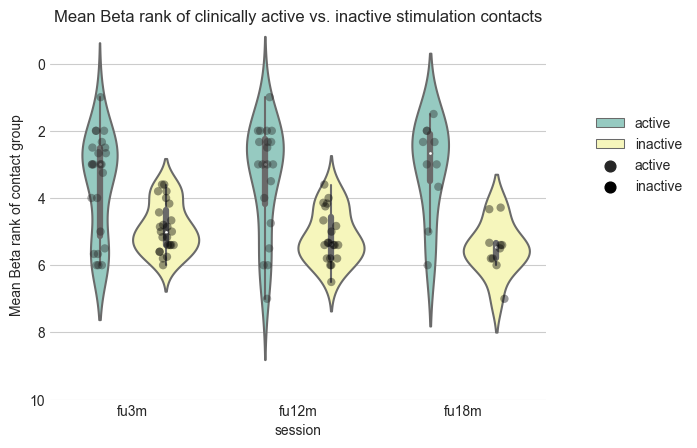

In [9]:
resultCorrelation = activeStimContacts.correlateActiveClinicalContacts_monopolarPSDRanks(
    incl_sub=["017", "019", "021", "024", "025", "026", "028", "029", "030", "031", "032", "033", "038"],
    freqBand="beta",
    rank_or_psd="rank", 
    singleContacts_or_average="averageContacts"
)

# TODO: do the same analysis but instead use relative beta psd values ranging from 0 to 1 (stretched, so the electrodes are comparable)

In [10]:
resultCorrelation["description_results"]

,number_observations,min_and_max,mean,variance,skewness,kurtosis
fu3m_active_rank_averageContacts,24,"(1.0, 6.0)",3.572917,2.340165,0.445678,-1.097573
fu3m_inactive_rank_averageContacts,24,"(3.6, 6.0)",4.885813,0.535567,-0.438947,-0.977586
fu12m_active_rank_averageContacts,20,"(1.0, 7.0)",3.3625,2.711458,0.848018,-0.396267
fu12m_inactive_rank_averageContacts,20,"(3.6, 6.5)",5.14131,0.61702,-0.356657,-0.815965
fu18m_active_rank_averageContacts,10,"(1.5, 6.0)",3.083333,2.057099,0.980286,-0.209401
fu18m_inactive_rank_averageContacts,10,"(4.285714285714286, 7.0)",5.485238,0.617911,0.100133,-0.029721


In [11]:
resultCorrelation["significance_results"]

,W-val,alternative,p-val,RBC,CLES,comparison_rank_averageContacts
Wilcoxon,42.5,two-sided,0.001238,-0.716667,0.264757,fu3m_active_fu3m_inactive
Wilcoxon,26.5,two-sided,0.001986,-0.747619,0.193750,fu12m_active_fu12m_inactive
Wilcoxon,3.0,two-sided,0.009766,-0.890909,0.105000,fu18m_active_fu18m_inactive


In [ ]:
# describe arrays
resultCorrelation["data_MonoBeta8Ranks"]

In [ ]:
ses_clinicalUse= ["fu3m_active", "fu3m_inactive", "fu12m_active", "fu12m_inactive", "fu18m_active", "fu18m_inactive"]
pairs = list(combinations(ses_clinicalUse, 2))
all_results_mwu = []
describe_arrays = {}


# pair = tuple e.g. postop, fu3m
for pair in pairs:

    firstInPair = dataframe.loc[(dataframe.session_clinicalUse == pair[0])]
    firstInPair = np.array(firstInPair.MEAN_beta_rank.values)

    secondInPair = dataframe.loc[(dataframe.session_clinicalUse == pair[1])]
    secondInPair = np.array(secondInPair.MEAN_beta_rank.values)    

    # Perform Mann-Whitney Test
    results_mwu = pg.mwu(firstInPair, secondInPair) # pair is always a tuple, comparing first and second component of this tuple
    results_mwu['comparison'] = '_'.join(pair) # new column "comparison" with the pair being compared e.g. fu3m_active and fu3m_inactive

    all_results_mwu.append(results_mwu)


# describe all 6 groups
for s_c in ses_clinicalUse:

    # get array of each group
    group = dataframe.loc[(dataframe.session_clinicalUse == s_c)]
    group = np.array(group.MEAN_beta_rank.values)

    description = scipy.stats.describe(group)

    describe_arrays[s_c] = description

description_results = pd.DataFrame(describe_arrays)
description_results.rename(index={0: "number_observations", 1: "min_and_max", 2: "mean", 3: "variance", 4: "skewness", 5: "kurtosis"}, inplace=True)
description_results = description_results.transpose()


significance_results = pd.concat(all_results_mwu)
significance_results

In [ ]:
fig=plt.figure()
ax = fig.add_subplot()



sns.violinplot(data=dataframe, x="session_clinicalUse", y="MEAN_beta_rank", hue="clinicalUse", palette="Set2", inner="box", ax=ax) #split=True)

ses_clinicalUse= [("fu3m_active", "fu3m_inactive"), ("fu12m_active", "fu12m_inactive"), ("fu18m_active", "fu18m_inactive")]
pairs = list(combinations(ses_clinicalUse, 2))

annotator = Annotator(ax, ses_clinicalUse, data=dataframe, x='session_clinicalUse', y="MEAN_beta_rank")
annotator.configure(test='Mann-Whitney', text_format='simple', loc="outside")
annotator.apply_and_annotate()

sns.stripplot(
    data=dataframe,
    x="session_clinicalUse",
    y="MEAN_beta_rank",
    hue="clinicalUse",
    ax=ax,
    size=7,
    color="black",
    alpha=0.4, # Transparency of dots
    dodge=True, # datapoints of groups active, inactive are plotted next to each other
)

sns.despine(left=True, bottom=True) # get rid of figure frame

# adjust x ticks to only show sessions
# labels = [item.get_text() for item in ax.get_xticklabels()]
# labels[0] = "3MFU"
# labels[1] = "12MFU"
# labels[2] = "18MFU"

# ax.set_xticks([0.5,2.5,4.5])
# ax.set_xticklabels(["3MFU", "12MFU", "18MFU"])
# ax.tick_params(axis="x", pad=15)

plt.title("Mean Beta rank of clinically active vs. inactive stimulation contacts")
plt.ylabel("MEAN_beta_rank")
plt.ylim(10, -1)
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 0.8))
plt.tight_layout()

In [ ]:
fig=plt.figure()
ax = fig.add_subplot()



sns.violinplot(data=dataframe, x="session_clinicalUse", y="MEAN_beta_rank", hue="clinicalUse", palette="Set2", inner="box", ax=ax)

ses_clinicalUse= [("fu3m_active", "fu3m_inactive"), ("fu12m_active", "fu12m_inactive"), ("fu18m_active", "fu18m_inactive")]
# pairs = list(combinations(ses_clinicalUse, 2))

annotator = Annotator(ax, ses_clinicalUse, data=dataframe, x='session_clinicalUse', y="MEAN_beta_rank")
annotator.configure(test='Mann-Whitney', text_format='simple', loc="outside")
annotator.apply_and_annotate()

sns.stripplot(
    data=dataframe,
    x="session_clinicalUse",
    y="MEAN_beta_rank",
    hue="clinicalUse",
    ax=ax,
    size=7,
    color="black",
    alpha=0.4, # Transparency of dots
    dodge=True, # datapoints of groups active, inactive are plotted next to each other
)

sns.despine(left=True, bottom=True) # get rid of figure frame

# adjust x ticks to only show sessions
ax.set_xticks([0.5,2.5,4.5])
ax.set_xticklabels(["fu3m", "fu12m", "fu18m"])

plt.title("Mean Beta rank of clinically active vs. inactive stimulation contacts")
plt.ylabel("MEAN_beta_rank")
plt.ylim(10, -1)
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 0.8))
plt.tight_layout()

### 2.2 Beta normalized per electrode relative to highest beta (=1.0)

pickle file loaded:  GroupMonopolar_weightedPsdCoordinateDistance_relToRank1_beta_rawPsd_band-pass.pickle 
loaded from:  c:\Users\jebe12\Research\Longterm_beta_project\results
Excel file loaded:  BestClinicalStimulation.xlsx 
loaded from:  c:\Users\jebe12\Research\Longterm_beta_project\data
new files:  ClinicalActiveVsNonactiveContacts_relativeToRank1_psd_beta_averageContacts.pickle 
and: ClinicalActiveVsNonactiveContacts_statistics_relativeToRank1_psd_beta_averageContacts.pickle 
written in in:  c:\Users\jebe12\Research\Longterm_beta_project\results 
new figure: ClinicalActiveVsNonactiveContacts_relativeToRank1_psd_beta__averageContacts.png 
written in:  c:\Users\jebe12\Research\Longterm_beta_project\figures


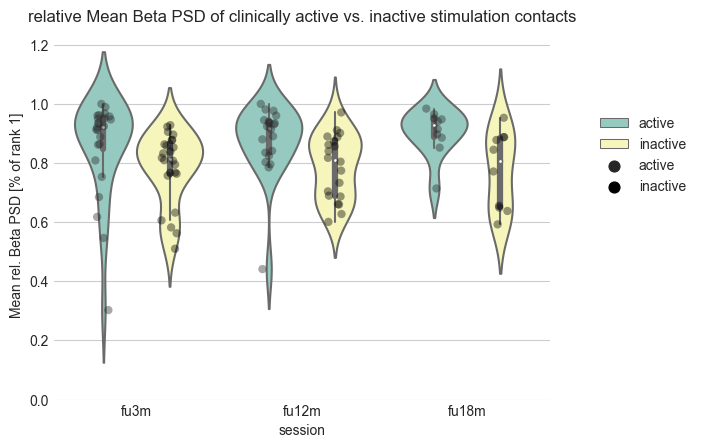

In [19]:
correlateMonoRef_PSDtoRank1 = activeStimContacts.correlateActiveClinicalContacts_monopolPSDrelToRank1(
    filterSignal="band-pass",
    normalization="rawPsd",
    freqBand="beta",
    singleContacts_or_average="averageContacts"
)

In [20]:
correlateMonoRef_PSDtoRank1["weightedByCoordinate_Dataframe"].head()

,contact,coord_z,coord_xy,subject_hemisphere,session,averaged_monopolar_PSD_beta,Rank8contacts,relativePSD_to_beta_Rank1from8
0,0,0.0+0.0j,0.000000+0.000000j,017_Right,fu3m,0.206574,8.0,0.783786
1,3,6.0+0.0j,0.000000+0.000000j,017_Right,fu3m,0.263559,1.0,1.000000
2,1A,2.0+0.0j,0.650000+0.000000j,017_Right,fu3m,0.242557,5.0,0.920316
3,1B,2.0+0.0j,-0.325000+0.562917j,017_Right,fu3m,0.235433,7.0,0.893283
4,1C,2.0+0.0j,-0.325000-0.562917j,017_Right,fu3m,0.238925,6.0,0.906535


In [21]:
correlateMonoRef_PSDtoRank1["data_MonoBeta8Ranks"].head()

,subject_hemisphere,session,MEAN_beta_rank,MEANrelToRank1psd,clinicalUse,session_clinicalUse
017_Right_fu3m_active,017_Right,fu3m,5.000000,0.920316,active,fu3m_active
017_Right_fu3m_inactive,017_Right,fu3m,4.428571,0.928176,inactive,fu3m_inactive
017_Right_fu12m_active,017_Right,fu12m,2.500000,0.785359,active,fu12m_active
017_Right_fu12m_inactive,017_Right,fu12m,6.500000,0.600950,inactive,fu12m_inactive
017_Left_fu3m_active,017_Left,fu3m,4.000000,0.888601,active,fu3m_active


In [22]:
correlateMonoRef_PSDtoRank1["results_dictionary"]["significance_results"]

,W-val,alternative,p-val,RBC,CLES,comparison_relativePsdToRank1_averageContacts
Wilcoxon,68.0,two-sided,0.017870,0.546667,0.753472,fu3m_active_fu3m_inactive
Wilcoxon,34.0,two-sided,0.006390,0.676190,0.762500,fu12m_active_fu12m_inactive
Wilcoxon,0.0,two-sided,0.001953,1.000000,0.820000,fu18m_active_fu18m_inactive


In [23]:

correlateMonoRef_PSDtoRank1["results_dictionary"]["description_results"]

,number_observations,min_and_max,mean,variance,skewness,kurtosis
fu3m_active_averageContacts,24,"(0.3026663776335989, 1.0)",0.856419,0.027787,-1.965771,3.408567
fu3m_inactive_averageContacts,24,"(0.5100910438855122, 0.9281764620099794)",0.784832,0.014375,-0.965156,-0.192224
fu12m_active_averageContacts,20,"(0.4412559315594231, 1.0)",0.87695,0.014795,-2.365648,6.304756
fu12m_inactive_averageContacts,20,"(0.6009504562069026, 0.9712032890307591)",0.787677,0.011929,-0.177566,-1.243993
fu18m_active_averageContacts,10,"(0.7140489728455736, 0.9841013634239277)",0.905325,0.006102,-1.531473,1.666023
fu18m_inactive_averageContacts,10,"(0.5925656320881224, 0.9531112974116278)",0.775784,0.017207,-0.144199,-1.586393


### 2.3 Beta normalized per electrode relative to highest and lowest beta (0.0 - 1.0)

pickle file loaded:  monopol_rel_psd_from0To8_beta_rawPsd_band-pass.pickle 
loaded from:  c:\Users\jebe12\Research\Longterm_beta_project\results
new files:  ClinicalActiveVsNonactiveContacts_rel_psd_0_to_1_beta_averageContacts.pickle 
and: ClinicalActiveVsNonactiveContacts_statistics_rel_psd_0_to_1_beta_averageContacts.pickle 
written in in:  c:\Users\jebe12\Research\Longterm_beta_project\results 
new figure: ClinicalActiveVsNonactiveContacts_rel_psd_0_to_1_beta__averageContacts.png 
written in:  c:\Users\jebe12\Research\Longterm_beta_project\figures


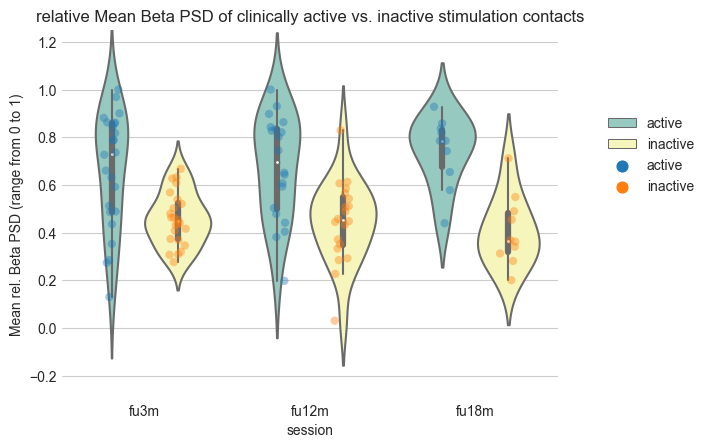

In [12]:
active_vs_inactive = activeStimContacts.active_vs_inactive_contacts_monopolPSD(
    filterSignal="band-pass",
    normalization="rawPsd",
    freqBand="beta",
    singleContacts_or_average="averageContacts"
)

# TODO: color code each subject
# what statistical test can I use to compare active vs inactive if sample sizes of single contacts are different?

In [17]:
active_vs_inactive["results_dictionary"]["significance_results"]

,W-val,alternative,p-val,RBC,CLES,comparison_relativePsdToRank1_averageContacts
Wilcoxon,48.0,two-sided,0.002516,0.680000,0.767361,fu3m_active_fu3m_inactive
Wilcoxon,27.0,two-sided,0.002325,0.742857,0.787500,fu12m_active_fu12m_inactive
Wilcoxon,0.0,two-sided,0.001953,1.000000,0.940000,fu18m_active_fu18m_inactive


In [18]:
active_vs_inactive["results_dictionary"]["description_results"]

,number_observations,min_and_max,mean,variance,skewness,kurtosis
fu3m_active_averageContacts,24,"(0.1299940935730989, 1.0)",0.6617,0.058356,-0.590657,-0.717699
fu3m_inactive_averageContacts,24,"(0.2766563688285066, 0.6678130339626598)",0.456828,0.012221,0.255682,-0.819237
fu12m_active_averageContacts,20,"(0.19793822740065792, 1.0)",0.673343,0.047197,-0.467585,-0.732703
fu12m_inactive_averageContacts,20,"(0.03098309601885988, 0.8291354380495756)",0.446257,0.028974,-0.240253,0.77301
fu18m_active_averageContacts,10,"(0.43989002175094477, 0.9280632824894369)",0.74281,0.021393,-0.883318,-0.117465
fu18m_inactive_averageContacts,10,"(0.20074907220995758, 0.7119152811764736)",0.407333,0.021926,0.710592,-0.112462


In [13]:
filterSignal="band-pass"
normalization="rawPsd"
freqBand="beta"

data_monopol_rel_0_to_1 = loadResults.load_monopol_rel_psd_from0To8_pickle(
        filterSignal=filterSignal,
        normalization=normalization,
        freqBand=freqBand)

data_MonoBeta8Ranks = data_monopol_rel_0_to_1

# add another column with session and clinical aggregated for statistical tests (Annotatator)
data_MonoBeta8Ranks["session_clinicalUse"] = data_MonoBeta8Ranks[["session", "clinicalUse"]].agg('_'.join, axis=1)

pickle file loaded:  monopol_rel_psd_from0To8_beta_rawPsd_band-pass.pickle 
loaded from:  c:\Users\jebe12\Research\Longterm_beta_project\results


In [14]:
data_MonoBeta8Ranks.head()

,contact,coord_z,coord_xy,subject_hemisphere,session,averaged_monopolar_PSD_beta,Rank8contacts,relativePSD_beta_from_0_to_1,relativePSD_beta_to_mean_std,currentPolarity,clinicalUse,session_clinicalUse
0,1A,2.0+0.0j,0.650000+0.000000j,017_Right,fu3m,0.242557,5.0,0.631459,-0.098256,1.0,active,fu3m_active
1,1C,2.0+0.0j,-0.325000-0.562917j,017_Left,fu3m,0.134140,6.0,0.153724,-0.811742,0.5,active,fu3m_active
2,2A,4.0+0.0j,0.650000+0.000000j,017_Left,fu3m,0.158134,2.0,0.823492,1.009836,0.5,active,fu3m_active
3,3,6.0+0.0j,0.000000+0.000000j,017_Right,fu12m,0.428184,1.0,1.000000,2.251914,0.25,active,fu12m_active
4,2A,4.0+0.0j,0.650000+0.000000j,017_Right,fu12m,0.305900,3.0,0.306505,0.156010,0.25,active,fu12m_active


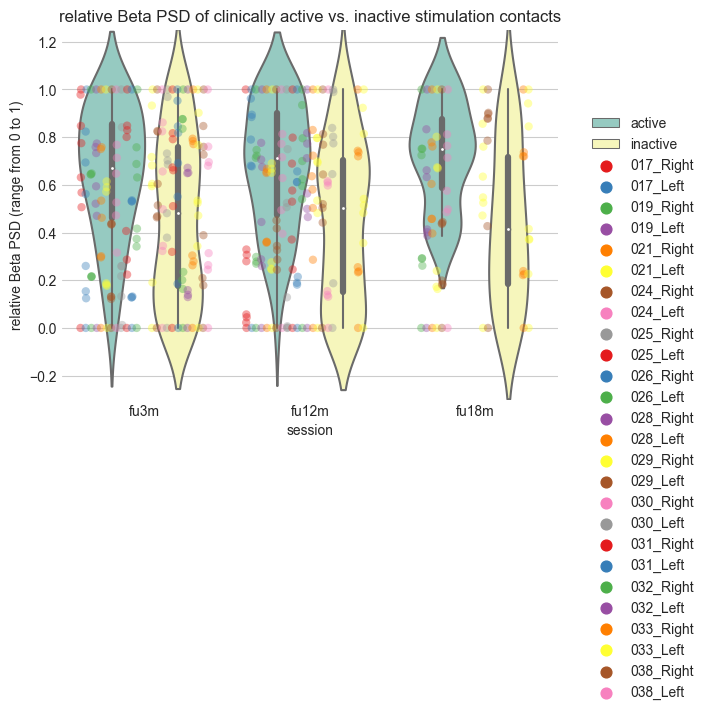

In [15]:
y_values = "relativePSD_beta_from_0_to_1"
y_label = "relative Beta PSD (range from 0 to 1)"
title = "relative Beta PSD of clinically active vs. inactive stimulation contacts"
y_lim = -0.3, 1.25


fig=plt.figure()
ax = fig.add_subplot()

# sns.violinplot(data=data_MonoBeta8Ranks, x="session_clinicalUse", y=y_values, hue="clinicalUse", palette="Set2", inner="box", ax=ax)
sns.violinplot(data=data_MonoBeta8Ranks, x="session", y=y_values, hue="clinicalUse", palette="Set3", inner="box", ax=ax)

sns.stripplot(
    data=data_MonoBeta8Ranks,
    x="session",
    y=y_values,
    hue="subject_hemisphere",
    ax=ax,
    size=6,
    palette="Set1",
    alpha=0.4, # Transparency of dots
    dodge=True, # datapoints of groups active, inactive are plotted next to each other
)

sns.despine(left=True, bottom=True) # get rid of figure frame



plt.title(title)
plt.ylabel(y_label)
plt.ylim(y_lim)
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 0.8))

## 3. Linear mixed effects model for predicting the current polarity of contacts

pip install statsmodels import statsmodels.formula.api as smf

In [ ]:
# load a Dataframe containing 
    # dependent variable = current polarity
    # fixed effect = monopolar PSD relative to highest PSD
    # and random effect = STN (subject_hemisphere)

In [24]:
freqBand = "beta"
sessions = ["fu3m", "fu12m", "fu18m"]
contacts = ["0", "1A", "1B", "1C", "2A", "2B", "2C", "3"]
weightedByCoordinate_Dataframe = pd.DataFrame() # concat all Dataframes from all sub, hem, sessions

# load Dataframe with PSD values of all channels and STNs
data_weightedByCoordinates = loadResults.load_GroupMonoRef_weightedPsdCoordinateDistance_pickle(
        filterSignal="band-pass",
        normalization="rawPsd",
        freqBand="beta")

# first check, which STNs and sessions exist in data 
sub_hem_keys = list(data_weightedByCoordinates.subject_hemisphere.unique())


for STN in sub_hem_keys:

    # select only one STN
    STN_data = data_weightedByCoordinates[data_weightedByCoordinates.subject_hemisphere == STN]


    for ses in sessions:

        # first check, if session exists in STN data
        if ses not in STN_data.session.values:
            continue

        
        # get the dataframe per session
        STN_session_data = STN_data[STN_data.session == ses]

        # choose only directional contacts and Ring contacts 0, 3 and rank again only the chosen contacts
        STN_session_data = STN_session_data[STN_session_data["contact"].isin(contacts)]
        STN_session_data["Rank8contacts"] = STN_session_data["averaged_monopolar_PSD_beta"].rank(ascending=False)
        STN_session_data_copy = STN_session_data.copy()
        STN_session_data_copy.drop(["rank"], axis=1, inplace=True)

        # calculate the relative PSD to the highest PSD of the 8 remaining contacts
        beta_rank_1 = STN_session_data_copy[STN_session_data_copy["Rank8contacts"] == 1.0] # taking the row containing 1.0 in rank
        beta_rank_1 = beta_rank_1[f"averaged_monopolar_PSD_{freqBand}"].values[0] # just taking psdAverage of rank 1.0

        # new column for rel. PSD to beta_rank_1 PSD
        STN_session_data_copy[f"relativePSD_to_{freqBand}_Rank1from8"] = STN_session_data_copy.apply(lambda row: row[f"averaged_monopolar_PSD_{freqBand}"] / beta_rank_1, axis=1) # in each row add to new value psd/beta_rank1
        STN_session_data_copy.drop([f"relativePSD_to_{freqBand}_Rank1"], axis=1, inplace=True)
        # session_weightedByCoordinates_copy["subject_hemisphere_monoChannel"] = session_weightedByCoordinates_copy[["subject_hemisphere", "monopolarChannels"]].agg("_".join, axis=1)
        

        weightedByCoordinate_Dataframe = pd.concat([weightedByCoordinate_Dataframe, STN_session_data_copy], ignore_index=True)

pickle file loaded:  GroupMonopolar_weightedPsdCoordinateDistance_relToRank1_beta_rawPsd_band-pass.pickle 
loaded from:  c:\Users\jebe12\Research\Longterm_beta_project\results


In [25]:
weightedByCoordinate_Dataframe.head()

,contact,coord_z,coord_xy,subject_hemisphere,session,averaged_monopolar_PSD_beta,Rank8contacts,relativePSD_to_beta_Rank1from8
0,0,0.0+0.0j,0.000000+0.000000j,017_Right,fu3m,0.206574,8.0,0.783786
1,3,6.0+0.0j,0.000000+0.000000j,017_Right,fu3m,0.263559,1.0,1.000000
2,1A,2.0+0.0j,0.650000+0.000000j,017_Right,fu3m,0.242557,5.0,0.920316
3,1B,2.0+0.0j,-0.325000+0.562917j,017_Right,fu3m,0.235433,7.0,0.893283
4,1C,2.0+0.0j,-0.325000-0.562917j,017_Right,fu3m,0.238925,6.0,0.906535


In [26]:
#################### LOAD CLINICAL STIMULATION PARAMETERS #####################

bestClinicalStim_file = loadResults.load_BestClinicalStimulation_excel()

# get sheet with best clinical contacts
BestClinicalContacts = bestClinicalStim_file["BestClinicalContacts"]



##################### FILTER THE MONOBETA8RANKS_DF: clinically ACTIVE contacts #####################
activeMonoBeta8Ranks = pd.DataFrame()

for idx, row in BestClinicalContacts.iterrows():

    activeContacts = str(BestClinicalContacts.CathodalContact.values[idx]) # e.g. "2A_2B_2C_3"
    # split active Contacts into list with single contact strings
    activeContacts_list = activeContacts.split("_") # e.g. ["2A", "2B", "2C", "3"]

    sub_hem = BestClinicalContacts.subject_hemisphere.values[idx]
    session = BestClinicalContacts.session.values[idx]
    currentPolarity = BestClinicalContacts.currentPolarity.values[idx]

    # get rows with equal sub_hem and session and with monopolarChannel in the list of activeContacts
    sub_hem_ses_rows = weightedByCoordinate_Dataframe.loc[(weightedByCoordinate_Dataframe["subject_hemisphere"]==sub_hem) & (weightedByCoordinate_Dataframe["session"]==session) & (weightedByCoordinate_Dataframe["contact"].isin(activeContacts_list))]
    # add a column and fill the cell with the current Polarity
    sub_hem_ses_rows_copy = sub_hem_ses_rows.copy()
    sub_hem_ses_rows_copy["currentPolarity"] = currentPolarity
    
    # concatenate single rows to new Dataframe
    activeMonoBeta8Ranks = pd.concat([activeMonoBeta8Ranks, sub_hem_ses_rows_copy], ignore_index=True)

# add a column "clinicalUse" to the Dataframe and fill with "active"
activeMonoBeta8Ranks["clinicalUse"] = "active"




##################### FILTER THE MONOBETA8RANKS_DF: clinically INACTIVE contacts #####################
inactiveMonoBeta8Ranks = pd.DataFrame()

for idx, row in BestClinicalContacts.iterrows():

    inactiveContacts = str(BestClinicalContacts.InactiveContacts.values[idx]) # e.g. "2A_2B_2C_3"
    # split active Contacts into list with single contact strings
    inactiveContacts_list = inactiveContacts.split("_") # e.g. ["2A", "2B", "2C", "3"]

    sub_hem = BestClinicalContacts.subject_hemisphere.values[idx]
    session = BestClinicalContacts.session.values[idx]

    # get rows with equal sub_hem and session and with monopolarChannel in the list of activeContacts
    sub_hem_ses_rows = weightedByCoordinate_Dataframe.loc[(weightedByCoordinate_Dataframe["subject_hemisphere"]==sub_hem) & (weightedByCoordinate_Dataframe["session"]==session) & (weightedByCoordinate_Dataframe["contact"].isin(inactiveContacts_list))]
    # add a column and fill the cell with the current Polarity
    sub_hem_ses_rows_copy = sub_hem_ses_rows.copy()
    sub_hem_ses_rows_copy["currentPolarity"] = "0"

    # concatenate single rows to new Dataframe
    inactiveMonoBeta8Ranks = pd.concat([inactiveMonoBeta8Ranks, sub_hem_ses_rows_copy], ignore_index=True)

# add a column "clinicalUse" to the Dataframe and fill with "non_active"
inactiveMonoBeta8Ranks["clinicalUse"] = "inactive"



##################### CONCATENATE BOTH DATAFRAMES: CLINICALLY ACTIVE and INACTIVE CONTACTS #####################
active_and_inactive_MonoBeta8Ranks = pd.concat([activeMonoBeta8Ranks, inactiveMonoBeta8Ranks], ignore_index=True)

Excel file loaded:  BestClinicalStimulation.xlsx 
loaded from:  c:\Users\jebe12\Research\Longterm_beta_project\data


In [27]:
active_and_inactive_MonoBeta8Ranks

,contact,coord_z,coord_xy,subject_hemisphere,session,averaged_monopolar_PSD_beta,Rank8contacts,relativePSD_to_beta_Rank1from8,currentPolarity,clinicalUse
0,1A,2.0+0.0j,0.650000+0.000000j,017_Right,fu3m,0.242557,5.0,0.920316,1.0,active
1,1C,2.0+0.0j,-0.325000-0.562917j,017_Left,fu3m,0.134140,6.0,0.815652,0.5,active
2,2A,4.0+0.0j,0.650000+0.000000j,017_Left,fu3m,0.158134,2.0,0.961551,0.5,active
3,3,6.0+0.0j,0.000000+0.000000j,017_Right,fu12m,0.428184,1.0,1.000000,0.25,active
4,2A,4.0+0.0j,0.650000+0.000000j,017_Right,fu12m,0.305900,3.0,0.714413,0.25,active
...,...,...,...,...,...,...,...,...,...,...
427,0,0.0+0.0j,0.000000+0.000000j,038_Left,fu3m,2.446689,1.0,1.000000,0,inactive
428,3,6.0+0.0j,0.000000+0.000000j,038_Left,fu3m,0.918773,8.0,0.375517,0,inactive
429,1A,2.0+0.0j,0.650000+0.000000j,038_Left,fu3m,1.981272,3.0,0.809777,0,inactive
430,1B,2.0+0.0j,-0.325000+0.562917j,038_Left,fu3m,2.080709,2.0,0.850418,0,inactive


In [28]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

active_and_inactive_MonoBeta8Ranks["group"] = le.fit_transform(active_and_inactive_MonoBeta8Ranks["subject_hemisphere"])

active_and_inactive_MonoBeta8Ranks["currentPolarity"] = active_and_inactive_MonoBeta8Ranks["currentPolarity"].astype(float)

In [29]:
active_and_inactive_MonoBeta8Ranks.head()

,contact,coord_z,coord_xy,subject_hemisphere,session,averaged_monopolar_PSD_beta,Rank8contacts,relativePSD_to_beta_Rank1from8,currentPolarity,clinicalUse,group
0,1A,2.0+0.0j,0.650000+0.000000j,017_Right,fu3m,0.242557,5.0,0.920316,1.00,active,1
1,1C,2.0+0.0j,-0.325000-0.562917j,017_Left,fu3m,0.134140,6.0,0.815652,0.50,active,0
2,2A,4.0+0.0j,0.650000+0.000000j,017_Left,fu3m,0.158134,2.0,0.961551,0.50,active,0
3,3,6.0+0.0j,0.000000+0.000000j,017_Right,fu12m,0.428184,1.0,1.000000,0.25,active,1
4,2A,4.0+0.0j,0.650000+0.000000j,017_Right,fu12m,0.305900,3.0,0.714413,0.25,active,1


In [30]:
independent_variable = active_and_inactive_MonoBeta8Ranks["relativePSD_to_beta_Rank1from8"]
dependent_variable = active_and_inactive_MonoBeta8Ranks["currentPolarity"]

random_effect = active_and_inactive_MonoBeta8Ranks["subject_hemisphere"]

In [ ]:
active_and_inactive_MonoBeta8Ranks["currentPolarity"]

c:\Users\jebe12\anaconda3\envs\bssu\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\jebe12\anaconda3\envs\bssu\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\jebe12\anaconda3\envs\bssu\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\jebe12\anaconda3\envs\bssu\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
c:\Users\jebe12\anaconda3\envs\bssu\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check ml

                        Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         currentPolarity
No. Observations:         432             Method:                     REML           
No. Groups:               26              Scale:                      0.0383         
Min. group size:          8               Log-Likelihood:             83.0134        
Max. group size:          24              Converged:                  No             
Mean group size:          16.6                                                       
-------------------------------------------------------------------------------------
                                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                  -0.139    0.053 -2.634 0.008 -0.243 -0.036
relativePSD_to_beta_Rank1from8              0.321    0.062  5.201 0.000  0.200

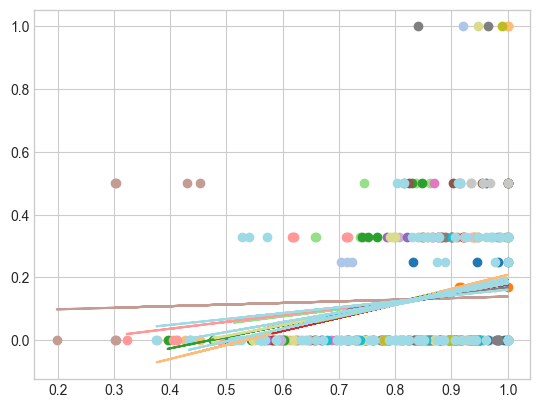

In [31]:
result = smf.mixedlm("currentPolarity ~ relativePSD_to_beta_Rank1from8", data=active_and_inactive_MonoBeta8Ranks, groups="group",
                     re_formula="1 + relativePSD_to_beta_Rank1from8").fit()
print(result.summary())

yp = result.fittedvalues
active_and_inactive_MonoBeta8Ranks["predictions"] = yp

for group in active_and_inactive_MonoBeta8Ranks.group.unique():
    sub_data = active_and_inactive_MonoBeta8Ranks[active_and_inactive_MonoBeta8Ranks.group==group]

    plt.scatter(sub_data["relativePSD_to_beta_Rank1from8"],sub_data["currentPolarity"],color=plt.cm.tab20(group), label="_nolegend_")
    plt.plot(sub_data["relativePSD_to_beta_Rank1from8"],sub_data["predictions"],color=plt.cm.tab20(group))

In [32]:
result.cov_params()

,Intercept,relativePSD_to_beta_Rank1from8,group Var,group x relativePSD_to_beta_Rank1from8 Cov,relativePSD_to_beta_Rank1from8 Var
Intercept,0.002787,-0.003195,-0.001118,0.000053,0.003441
relativePSD_to_beta_Rank1from8,-0.003195,0.003808,0.000867,0.000279,-0.004222
group Var,-0.001118,0.000867,0.078754,-0.085857,0.084085
group x relativePSD_to_beta_Rank1from8 Cov,0.000053,0.000279,-0.085857,0.105929,-0.123935
relativePSD_to_beta_Rank1from8 Var,0.003441,-0.004222,0.084085,-0.123935,0.171020


In [33]:
yp

0      0.155004
1      0.121479
2      0.162618
3      0.179041
4      0.092889
         ...   
427    0.161294
428    0.044453
429    0.125703
430    0.133307
431    0.123940
Length: 432, dtype: float64

In [34]:
# try the linear mixed effects model for seperate sessions (fu3m, fu12m, fu18m) and for different thresholds (relPSD = 1.0, > 0.9, > 0.8, > 0.7 etc)

# first try for all values

independent_variable = active_and_inactive_MonoBeta8Ranks["relativePSD_to_beta_Rank1from8"]
dependent_variable = active_and_inactive_MonoBeta8Ranks["currentPolarity"]



formula = "currentPolarity ~ relativePSD_to_beta_Rank1from8 + (relativePSD_to_beta_Rank1from8|subject_hemisphere)"

model = sm.MixedLM(active_and_inactive_MonoBeta8Ranks["currentPolarity"], data=active_and_inactive_MonoBeta8Ranks, groups=active_and_inactive_MonoBeta8Ranks["subject_hemisphere"])

TypeError: MixedLM.__init__() missing 1 required positional argument: 'exog'

In [ ]:
independent_variable = active_and_inactive_MonoBeta8Ranks["relativePSD_to_beta_Rank1from8"]
dependent_variable = active_and_inactive_MonoBeta8Ranks["currentPolarity"]

y, x = dmatrices("currentPolarity ~ relativePSD_to_beta_Rank1from8", data=active_and_inactive_MonoBeta8Ranks)

In [ ]:
linear_model = sm.OLS(y,x).fit()

## 4. Logistic regression to predict clinical activity based on beta power

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [35]:
monopol_relPsd_0_to_8 = loadResults.load_monopol_rel_psd_from0To8_pickle(
    filterSignal="band-pass",
    normalization="rawPsd",
    freqBand="beta"
)

pickle file loaded:  monopol_rel_psd_from0To8_beta_rawPsd_band-pass.pickle 
loaded from:  c:\Users\jebe12\Research\Longterm_beta_project\results


In [36]:
monopol_relPsd_0_to_8

,contact,coord_z,coord_xy,subject_hemisphere,session,averaged_monopolar_PSD_beta,Rank8contacts,relativePSD_beta_from_0_to_1,relativePSD_beta_to_mean_std,currentPolarity,clinicalUse
0,1A,2.0+0.0j,0.650000+0.000000j,017_Right,fu3m,0.242557,5.0,0.631459,-0.098256,1.0,active
1,1C,2.0+0.0j,-0.325000-0.562917j,017_Left,fu3m,0.134140,6.0,0.153724,-0.811742,0.5,active
2,2A,4.0+0.0j,0.650000+0.000000j,017_Left,fu3m,0.158134,2.0,0.823492,1.009836,0.5,active
3,3,6.0+0.0j,0.000000+0.000000j,017_Right,fu12m,0.428184,1.0,1.000000,2.251914,0.25,active
4,2A,4.0+0.0j,0.650000+0.000000j,017_Right,fu12m,0.305900,3.0,0.306505,0.156010,0.25,active
...,...,...,...,...,...,...,...,...,...,...,...
427,0,0.0+0.0j,0.000000+0.000000j,038_Left,fu3m,2.446689,1.0,1.000000,1.500028,0,inactive
428,3,6.0+0.0j,0.000000+0.000000j,038_Left,fu3m,0.918773,8.0,0.000000,-1.468703,0,inactive
429,1A,2.0+0.0j,0.650000+0.000000j,038_Left,fu3m,1.981272,3.0,0.695391,0.595726,0,inactive
430,1B,2.0+0.0j,-0.325000+0.562917j,038_Left,fu3m,2.080709,2.0,0.760471,0.788931,0,inactive


In [37]:
shortDF = monopol_relPsd_0_to_8.loc[(monopol_relPsd_0_to_8.session == "fu3m")]

shortDF.head()

,contact,coord_z,coord_xy,subject_hemisphere,session,averaged_monopolar_PSD_beta,Rank8contacts,relativePSD_beta_from_0_to_1,relativePSD_beta_to_mean_std,currentPolarity,clinicalUse
0,1A,2.0+0.0j,0.650000+0.000000j,017_Right,fu3m,0.242557,5.0,0.631459,-0.098256,1.0,active
1,1C,2.0+0.0j,-0.325000-0.562917j,017_Left,fu3m,0.134140,6.0,0.153724,-0.811742,0.5,active
2,2A,4.0+0.0j,0.650000+0.000000j,017_Left,fu3m,0.158134,2.0,0.823492,1.009836,0.5,active
11,0,0.0+0.0j,0.000000+0.000000j,019_Right,fu3m,0.796842,1.0,1.000000,1.649256,1.0,active
12,1A,2.0+0.0j,0.650000+0.000000j,019_Left,fu3m,0.524650,1.0,1.000000,1.327071,0.33,active


In [39]:
# exchange active with 1 and inactive with 0
clinicalUse_as_int = shortDF.replace(to_replace="active", value=1)
clinicalUse_as_int = clinicalUse_as_int.replace(to_replace="inactive", value=0)
clinicalUse_as_int.head()

,contact,coord_z,coord_xy,subject_hemisphere,session,averaged_monopolar_PSD_beta,Rank8contacts,relativePSD_beta_from_0_to_1,relativePSD_beta_to_mean_std,currentPolarity,clinicalUse
0,1A,2.0+0.0j,0.650000+0.000000j,017_Right,fu3m,0.242557,5.0,0.631459,-0.098256,1.0,1
1,1C,2.0+0.0j,-0.325000-0.562917j,017_Left,fu3m,0.134140,6.0,0.153724,-0.811742,0.5,1
2,2A,4.0+0.0j,0.650000+0.000000j,017_Left,fu3m,0.158134,2.0,0.823492,1.009836,0.5,1
11,0,0.0+0.0j,0.000000+0.000000j,019_Right,fu3m,0.796842,1.0,1.000000,1.649256,1.0,1
12,1A,2.0+0.0j,0.650000+0.000000j,019_Left,fu3m,0.524650,1.0,1.000000,1.327071,0.33,1


In [40]:
# split the data into a test dataset = 0.25
x_train, x_test, y_train, y_test = train_test_split(clinicalUse_as_int.relativePSD_beta_from_0_to_1.values, 
                                                    clinicalUse_as_int.clinicalUse.values, 
                                                    test_size=0.25, 
                                                    random_state=16)

# x = relativePSD_to_beta_Rank1from8 column
# y = clinicalUse column

{'whiskers': [<matplotlib.lines.Line2D at 0x2196441a8c0>,
 'caps': [<matplotlib.lines.Line2D at 0x21964418190>,
 'boxes': [<matplotlib.lines.Line2D at 0x2196441a050>,
 'medians': [<matplotlib.lines.Line2D at 0x2196441ae60>,
 'fliers': [<matplotlib.lines.Line2D at 0x2196441b160>,
 'means': []}

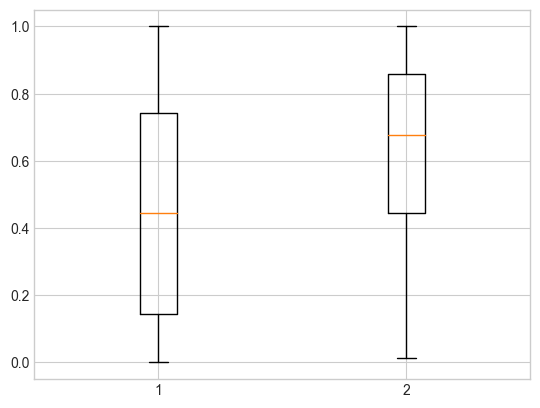

In [41]:
meh =[np.array(x_train[y_train==0]).ravel(),
np.array(x_train[y_train==1]).ravel()]
plt.boxplot(meh)

In [42]:
x_train = x_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)

In [43]:
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression(C=100,  solver='newton-cg')

# train the model on the data
logisticRegr.fit(x_train, y_train)

LogisticRegression(C=100, solver='newton-cg')

In [44]:
y_pred = logisticRegr.predict(x_test)
y_pred

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1], dtype=int64)

In [45]:
from sklearn.model_selection import  RepeatedStratifiedKFold, GridSearchCV
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

model = LogisticRegression()


# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='balanced_accuracy',error_score=0)
grid_result = grid_search.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.500000 using {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.496389 (0.093415) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.496389 (0.093415) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.496389 (0.093415) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.488889 (0.092209) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.488889 (0.092209) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.488889 (0.092209) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.493333 (0.028087) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.493333 (0.028087) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.500000 (0.000000) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.500000 (0.000000) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.500000 (0.000000) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.500000 (0.000000) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.500000 (0.000000) wit

In [46]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[30,  5],
       [11,  2]], dtype=int64)

Text(0.5, 427.9555555555555, 'Predicted label')

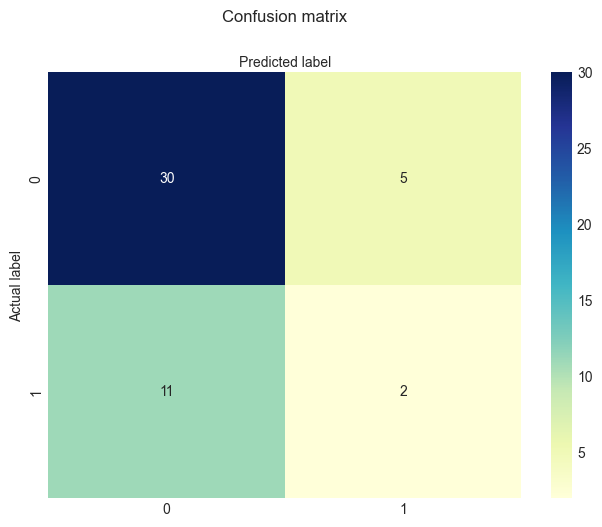

In [47]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [48]:
from sklearn.metrics import classification_report

target_names = ['inactive', 'active']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    inactive       0.73      0.86      0.79        35
      active       0.29      0.15      0.20        13

    accuracy                           0.67        48
   macro avg       0.51      0.51      0.49        48
weighted avg       0.61      0.67      0.63        48



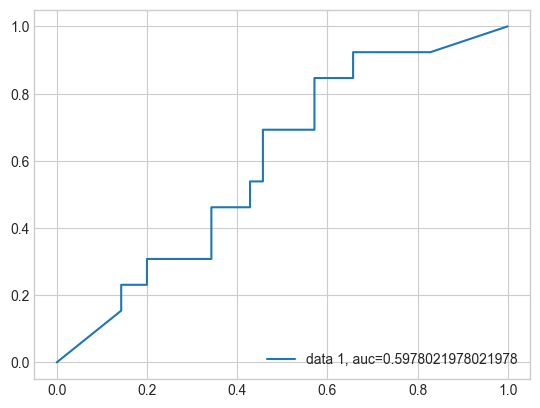

In [49]:
y_pred_proba = logisticRegr.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [50]:

logisticRegr.coef_

array([[1.9475485]])